# Imports and Utils

To generate plots run the following sections.

- all code cells under Imports and Utils
- all code cells under File Loading
- all code cells under Significance Testing

In [1]:
import os
import glob
import pickle
from pathlib import Path

import seaborn as sns  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 200)

from IPython.core.debugger import set_trace

import directory_structure as ds

%load_ext autoreload
%autoreload 2

In [2]:
def debug_groupby(groups):
    for name, grp in groups:
        display(grp)

class DataFrameIndexWrapper:
    def __init__(self, df):
        self.df = df
        
    def __getitem__(self, item):
        return self.df.loc[item]
    
    def __call__(self, *args, **kwargs):
        if len(args) == 0:
            args = df.columns
        index = [kwargs.get(idx, slice(None)) for idx in self.df.index.names]
        return self.df.loc[tuple(index), tuple(args)]
    
    def get_group_data(self, level, score):
        grps = self.df.groupby(level=level)
        dfs = []
        for name, df in grps:
            if isinstance(name, tuple):
                group_name = '-'.join(name)
            else:
                group_name = name
            grp_df = pd.DataFrame({
                'group': np.repeat([group_name], repeats=len(df)),
                'score': df[score].reset_index(drop=True), 
            })

            dfs.append(grp_df)
        dfs = pd.concat(dfs, axis=0)
        dfs.set_index('group', inplace=True)
        return dfs 

# File Loading

In [3]:
# target_dir = 'logocv-all-subjects-async'
target_dir = os.path.join('v2-ErrP-variations-March-3-2022', 
                          'logocv-v2-eegnet-async-upsample')
# target_dir = os.path.join('ErrP-variations-Jan-26-2022','logocv-svm-all-async')

target_file = '**/test-metrics.csv'

parent_dir = Path(ds.ROOT_DIR) / ds.EXPS_DIR

target_path = parent_dir / target_dir / target_file

target_path

PosixPath('/home/dev/mnt/scripts/classification/exps/v2-ErrP-variations-March-3-2022/logocv-v2-eegnet-async-upsample/**/test-metrics.csv')

In [4]:
list_files = glob.glob(str(target_path), recursive=True)

print(f"Found {len(list_files)} files")

subjects = 9 
tasks = 4
estimated_files = subjects * tasks
assert estimated_files == len(list_files), f"Number of files found {len(list_files)} does not match estimated {estimated_files}"

Found 36 files


#  DataFrame Building

In [5]:
rename_cols = {
    'dataset':'tar_dataset', 
    'subject':'tar_subject', 
    'trial':'tar_trial'
}

convert_type = {
    'subject': str,
    'trial': str,
}

exp_cols = ['tst_dataset', 'tst_subject', 'tst_trial']

mi = ['tst_dataset', 'tst_subject', 'tst_trial', 
      'tar_dataset', 'tar_subject', 'tar_trial']

list_dfs = []

def parse_exp(df):
    exp_values = df.exp.str.split("-", expand=True)
    # Insert exp columns at front of dataframe
    for col, index in zip(exp_cols[::-1], range(len(exp_cols))[::-1]):
        # print(f"Column: {col} Index: {index}")
        df.insert(0, col, exp_values[index])
    
    df.drop('exp', axis=1, inplace=True)
    return df

def convert_types(df):
    for col, t in convert_type.items():
        df[col] = df[col].astype(t)
    return df

for i in list_files:
    df = pd.read_csv(i)
    convert_types(df)
    df = parse_exp(df)
    df.rename(columns=rename_cols, inplace=True)
    list_dfs.append(df)

In [6]:
df = pd.concat(list_dfs)
df = df.set_index(mi).sort_index()
df

bACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
BGSInt      1           1         BGSInt      1           1          0.836468   
                                  BGSObs      1           1          0.765794   
                                                          10         0.729411   
                                                          2          0.801884   
                                                          3          0.699750   
...                                                                       ...   
OAOut       9           9         OAObs       9           6          0.497313   
                                                          7          0.544373   
                                                          8          0.556045   
                                                          9          0.537899   
                                  OAOut       9           9          0.844737   

                                                                          ACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
BGSInt      1           1         BGSInt      1           1          0.886538   
                                  BGSObs      1           1          0.797729   
                                                          10         0.846679   
                                                          2          0.842515   
                                                          3          0.877126   
...                                                                       ...   
OAOut       9           9         OAObs       9           6          0.989311   
                                                          7          0.992477   
                                                          8          0.983396   
                                                          9          0.986631   
                                  OAOut       9           9          0.987879   

                                                                          tpr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
BGSInt      1           1         BGSInt      1           1          0.785714   
                                  BGSObs      1           1          0.733333   
                                                          10         0.608696   
                                                          2          0.760000   
                                                          3          0.516129   
...                                                                       ...   
OAOut       9           9         OAObs       9           6          0.000000   
                                                          7          0.090909   
                                                          8          0.125000   
                                                          9          0.083333   
                                  OAOut       9           9          0.700000   

                                                                          ppv  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
BGSInt      1           1         BGSInt      1           1          0.045082   
                                  BGSObs      1           1          0.028871   
                                                          10         0.055556   
                                                          2          0.068841   
                                                          3          0.071111   
...                                                                       ...   
OAOut       9           9         OAObs       9           6          0.000000   
                                                          7          0.200000   
                                                          8          0.040000   
                    

In [7]:
dfw = DataFrameIndexWrapper(df)
dfw('bACC', 'tpr', tst_dataset = "OAObs")

bACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           1         BGSInt      1           1          0.731884   
                                                          10         0.574305   
                                                          2          0.742908   
                                                          3          0.737796   
                                                          4          0.733254   
...                                                                       ...   
            9           9         OAOut       9           5          0.822735   
                                                          6          0.865505   
                                                          7          0.836286   
                                                          8          0.952157   
                                                          9          0.896814   

                                                                          tpr  
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial            
OAObs       1           1         BGSInt      1           1          0.642857  
                                                          10         0.200000  
                                                          2          0.652174  
                                                          3          0.631579  
                                                          4          0.608696  
...                                                                       ...  
            9           9         OAOut       9           5          0.727273  
                                                          6          0.833333  
                                                          7          0.777778  
                                                          8          1.000000  
                                                          9          0.900000  

[2790 rows x 2 columns]

In [8]:
dfw.get_group_data(['tst_dataset', 'tar_dataset'], score='bACC')

,score
group,
BGSInt-BGSInt,0.836468
BGSInt-BGSInt,0.757354
BGSInt-BGSInt,0.798863
BGSInt-BGSInt,0.806560
BGSInt-BGSInt,0.855242
...,...
OAOut-OAOut,0.882936
OAOut-OAOut,0.825867
OAOut-OAOut,0.873662


# Mean/Std Analysis

### Summary of test trial performance

Summary of test trial performance based on mean across all validaiton sets. Since each validation set measures the test set an average over test trials needs to be computed.

#### Single Trial

In [9]:
tar_df = dfw(
    tst_dataset = "OAObs", 
    tst_subject = "1",
    tst_trial='10',
    tar_dataset='BGSInt',
    tar_subject='1')
tar_df

bACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           10        BGSInt      1           1          0.795913   
                                                          10         0.602714   
                                                          2          0.789601   
                                                          3          0.678968   
                                                          4          0.622998   
                                                          5          0.682457   
                                                          6          0.801109   
                                                          7          0.669734   
                                                          8          0.589920   
                                                          9          0.662540   

                                                                          ACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           10        BGSInt      1           1          0.876442   
                                                          10         0.948106   
                                                          2          0.881573   
                                                          3          0.880413   
                                                          4          0.892293   
                                                          5          0.884484   
                                                          6          0.908421   
                                                          7          0.907299   
                                                          8          0.950584   
                                                          9          0.942766   

                                                                          tpr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           10        BGSInt      1           1          0.714286   
                                                          10         0.250000   
                                                          2          0.695652   
                                                          3          0.473684   
                                                          4          0.347826   
                                                          5          0.476190   
                                                          6          0.692308   
                                                          7          0.428571   
                                                          8          0.222222   
                                                          9          0.375000   

                                                                          ppv  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           10        BGSInt      1           1          0.038023   
                                                          10         0.055556   
                                                          2          0.059701   
                                                          3          0.037190   
                                                          4          0.035556   
                                                          5          0.042553   
                                                          6          0.050279   
                                                          7          0.034884   
                                                          8          0.048193   
                                                          9          0.088235   

                                                                          tnr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1      

In [10]:
tar_df.mean()

bACC    0.689595
ACC     0.907238
tpr     0.467574
ppv     0.049017
tnr     0.911617
F1      0.086501
nll     0.221162
PR      0.105981
ROC     0.803692
dtype: float64

#### All Trials

In [11]:
tar_df = dfw(
    tst_dataset = "OAObs", 
    tst_subject = "1", 
    tar_dataset='BGSInt',
    tar_subject='1')

grps = tar_df.groupby(level=['tst_trial'])

grps.mean()

,bACC,ACC,tpr,ppv,tnr,F1,nll,PR,ROC
tst_trial,,,,,,,,,
1,0.694439,0.882226,0.502835,0.041577,0.886043,0.074652,0.270006,0.106285,0.805494
10,0.689595,0.907238,0.467574,0.049017,0.911617,0.086501,0.221162,0.105981,0.803692
2,0.692271,0.913636,0.466442,0.052583,0.918099,0.091230,0.211394,0.113685,0.812707
3,0.674495,0.914561,0.429569,0.046919,0.919421,0.082404,0.212525,0.105199,0.788551
4,0.703720,0.915951,0.487190,0.056996,0.920250,0.098990,0.195938,0.131823,0.844729
5,0.654066,0.920601,0.382199,0.051620,0.925933,0.085096,0.201249,0.100274,0.771719
6,0.727930,0.881269,0.571518,0.047761,0.884343,0.086463,0.255815,0.118104,0.825809
7,0.689352,0.892440,0.482049,0.041486,0.896656,0.074388,0.255686,0.106034,0.791038
8,0.716532,0.903412,0.525882,0.053457,0.907182,0.094879,0.233021,0.118892,0.825173


In [12]:
debug_groupby(grps)

bACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           1         BGSInt      1           1          0.731884   
                                                          10         0.574305   
                                                          2          0.742908   
                                                          3          0.737796   
                                                          4          0.733254   
                                                          5          0.692419   
                                                          6          0.829501   
                                                          7          0.702228   
                                                          8          0.558387   
                                                          9          0.641707   

                                                                          ACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           1         BGSInt      1           1          0.819712   
                                                          10         0.940841   
                                                          2          0.831733   
                                                          3          0.842028   
                                                          4          0.855153   
                                                          5          0.857562   
                                                          6          0.888947   
                                                          7          0.901438   
                                                          8          0.942614   
                                                          9          0.942236   

                                                                          tpr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           1         BGSInt      1           1          0.642857   
                                                          10         0.200000   
                                                          2          0.652174   
                                                          3          0.631579   
                                                          4          0.608696   
                                                          5          0.523810   
                                                          6          0.769231   
                                                          7          0.500000   
                                                          8          0.166667   
                                                          9          0.333333   

                                                                          ppv  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           1         BGSInt      1           1          0.023747   
                                                          10         0.039216   
                                                          2          0.040000   
                                                          3          0.036810   
                                                          4          0.044164   
                                                          5          0.037671   
                                                          6          0.045872   
                                                          7          0.037838   
                                                          8          0.031250   
                                                          9          0.079208   

                                                                          tnr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1      

bACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           10        BGSInt      1           1          0.795913   
                                                          10         0.602714   
                                                          2          0.789601   
                                                          3          0.678968   
                                                          4          0.622998   
                                                          5          0.682457   
                                                          6          0.801109   
                                                          7          0.669734   
                                                          8          0.589920   
                                                          9          0.662540   

                                                                          ACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           10        BGSInt      1           1          0.876442   
                                                          10         0.948106   
                                                          2          0.881573   
                                                          3          0.880413   
                                                          4          0.892293   
                                                          5          0.884484   
                                                          6          0.908421   
                                                          7          0.907299   
                                                          8          0.950584   
                                                          9          0.942766   

                                                                          tpr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           10        BGSInt      1           1          0.714286   
                                                          10         0.250000   
                                                          2          0.695652   
                                                          3          0.473684   
                                                          4          0.347826   
                                                          5          0.476190   
                                                          6          0.692308   
                                                          7          0.428571   
                                                          8          0.222222   
                                                          9          0.375000   

                                                                          ppv  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           10        BGSInt      1           1          0.038023   
                                                          10         0.055556   
                                                          2          0.059701   
                                                          3          0.037190   
                                                          4          0.035556   
                                                          5          0.042553   
                                                          6          0.050279   
                                                          7          0.034884   
                                                          8          0.048193   
                                                          9          0.088235   

                                                                          tnr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1      

bACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           2         BGSInt      1           1          0.792525   
                                                          10         0.581647   
                                                          2          0.769710   
                                                          3          0.704539   
                                                          4          0.713943   
                                                          5          0.685177   
                                                          6          0.770331   
                                                          7          0.710816   
                                                          8          0.568044   
                                                          9          0.625973   

                                                                          ACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           2         BGSInt      1           1          0.869712   
                                                          10         0.955371   
                                                          2          0.884774   
                                                          3          0.879429   
                                                          4          0.902043   
                                                          5          0.889868   
                                                          6          0.923158   
                                                          7          0.918487   
                                                          8          0.961743   
                                                          9          0.951775   

                                                                          tpr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           2         BGSInt      1           1          0.714286   
                                                          10         0.200000   
                                                          2          0.652174   
                                                          3          0.526316   
                                                          4          0.521739   
                                                          5          0.476190   
                                                          6          0.615385   
                                                          7          0.500000   
                                                          8          0.166667   
                                                          9          0.291667   

                                                                          ppv  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           2         BGSInt      1           1          0.036101   
                                                          10         0.054054   
                                                          2          0.057915   
                                                          3          0.040650   
                                                          4          0.056604   
                                                          5          0.044643   
                                                          6          0.053691   
                                                          7          0.045752   
                                                          8          0.050000   
                                                          9          0.086420   

                                                                          tnr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1      

bACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           3         BGSInt      1           1          0.795913   
                                                          10         0.552976   
                                                          2          0.729928   
                                                          3          0.681204   
                                                          4          0.669292   
                                                          5          0.663593   
                                                          6          0.849639   
                                                          7          0.640461   
                                                          8          0.536779   
                                                          9          0.625168   

                                                                          ACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           3         BGSInt      1           1          0.876442   
                                                          10         0.947587   
                                                          2          0.891175   
                                                          3          0.884843   
                                                          4          0.898793   
                                                          5          0.893784   
                                                          6          0.928947   
                                                          7          0.919552   
                                                          8          0.954304   
                                                          9          0.950185   

                                                                          tpr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           3         BGSInt      1           1          0.714286   
                                                          10         0.150000   
                                                          2          0.565217   
                                                          3          0.473684   
                                                          4          0.434783   
                                                          5          0.428571   
                                                          6          0.769231   
                                                          7          0.357143   
                                                          8          0.111111   
                                                          9          0.291667   

                                                                          ppv  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           3         BGSInt      1           1          0.038023   
                                                          10         0.034483   
                                                          2          0.053942   
                                                          3          0.038627   
                                                          4          0.046512   
                                                          5          0.042056   
                                                          6          0.070423   
                                                          7          0.034014   
                                                          8          0.027778   
                                                          9          0.083333   

                                                                          tnr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1      

bACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           4         BGSInt      1           1          0.797366   
                                                          10         0.629287   
                                                          2          0.744274   
                                                          3          0.761393   
                                                          4          0.651541   
                                                          5          0.682952   
                                                          6          0.815682   
                                                          7          0.749751   
                                                          8          0.536510   
                                                          9          0.668445   

                                                                          ACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           4         BGSInt      1           1          0.879327   
                                                          10         0.951738   
                                                          2          0.877000   
                                                          3          0.888780   
                                                          4          0.906221   
                                                          5          0.885463   
                                                          6          0.937368   
                                                          7          0.925413   
                                                          8          0.953773   
                                                          9          0.954425   

                                                                          tpr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           4         BGSInt      1           1          0.714286   
                                                          10         0.300000   
                                                          2          0.608696   
                                                          3          0.631579   
                                                          4          0.391304   
                                                          5          0.476190   
                                                          6          0.692308   
                                                          7          0.571429   
                                                          8          0.111111   
                                                          9          0.375000   

                                                                          ppv  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           4         BGSInt      1           1          0.038911   
                                                          10         0.070588   
                                                          2          0.051095   
                                                          3          0.051948   
                                                          4          0.045685   
                                                          5          0.042918   
                                                          6          0.072581   
                                                          7          0.056338   
                                                          8          0.027397   
                                                          9          0.112500   

                                                                          tnr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1      

bACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           5         BGSInt      1           1          0.755601   
                                                          10         0.562677   
                                                          2          0.721842   
                                                          3          0.655136   
                                                          4          0.650134   
                                                          5          0.649428   
                                                          6          0.734785   
                                                          7          0.648244   
                                                          8          0.571263   
                                                          9          0.591553   

                                                                          ACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           5         BGSInt      1           1          0.866827   
                                                          10         0.966788   
                                                          2          0.875171   
                                                          3          0.884843   
                                                          4          0.903435   
                                                          5          0.912384   
                                                          6          0.928421   
                                                          7          0.935003   
                                                          8          0.968119   
                                                          9          0.965024   

                                                                          tpr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           5         BGSInt      1           1          0.642857   
                                                          10         0.150000   
                                                          2          0.565217   
                                                          3          0.421053   
                                                          4          0.391304   
                                                          5          0.380952   
                                                          6          0.538462   
                                                          7          0.357143   
                                                          8          0.166667   
                                                          9          0.208333   

                                                                          ppv  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           5         BGSInt      1           1          0.032028   
                                                          10         0.060000   
                                                          2          0.047101   
                                                          3          0.034632   
                                                          4          0.044335   
                                                          5          0.045977   
                                                          6          0.051095   
                                                          7          0.042373   
                                                          8          0.062500   
                                                          9          0.096154   

                                                                          tnr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1      

bACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           6         BGSInt      1           1          0.770986   
                                                          10         0.592488   
                                                          2          0.769499   
                                                          3          0.788689   
                                                          4          0.737478   
                                                          5          0.692914   
                                                          6          0.831356   
                                                          7          0.697665   
                                                          8          0.640111   
                                                          9          0.758119   

                                                                          ACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           6         BGSInt      1           1          0.826923   
                                                          10         0.927867   
                                                          2          0.841792   
                                                          3          0.839567   
                                                          4          0.863510   
                                                          5          0.858541   
                                                          6          0.892632   
                                                          7          0.892381   
                                                          8          0.941020   
                                                          9          0.928458   

                                                                          tpr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           6         BGSInt      1           1          0.714286   
                                                          10         0.250000   
                                                          2          0.695652   
                                                          3          0.736842   
                                                          4          0.608696   
                                                          5          0.523810   
                                                          6          0.769231   
                                                          7          0.500000   
                                                          8          0.333333   
                                                          9          0.583333   

                                                                          ppv  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           6         BGSInt      1           1          0.027322   
                                                          10         0.038760   
                                                          2          0.045070   
                                                          3          0.041791   
                                                          4          0.046823   
                                                          5          0.037931   
                                                          6          0.047393   
                                                          7          0.034653   
                                                          8          0.057143   
                                                          9          0.100719   

                                                                          tnr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1      

bACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           7         BGSInt      1           1          0.841447   
                                                          10         0.549043   
                                                          2          0.774813   
                                                          3          0.687897   
                                                          4          0.659203   
                                                          5          0.674792   
                                                          6          0.801374   
                                                          7          0.743041   
                                                          8          0.560265   
                                                          9          0.601651   

                                                                          ACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           7         BGSInt      1           1          0.825962   
                                                          10         0.939803   
                                                          2          0.852309   
                                                          3          0.846457   
                                                          4          0.878830   
                                                          5          0.869310   
                                                          6          0.908947   
                                                          7          0.912094   
                                                          8          0.946334   
                                                          9          0.944356   

                                                                          tpr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           7         BGSInt      1           1          0.857143   
                                                          10         0.150000   
                                                          2          0.695652   
                                                          3          0.526316   
                                                          4          0.434783   
                                                          5          0.476190   
                                                          6          0.692308   
                                                          7          0.571429   
                                                          8          0.166667   
                                                          9          0.250000   

                                                                          ppv  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           7         BGSInt      1           1          0.032258   
                                                          10         0.029412   
                                                          2          0.048193   
                                                          3          0.031949   
                                                          4          0.038760   
                                                          5          0.037594   
                                                          6          0.050562   
                                                          7          0.047904   
                                                          8          0.033708   
                                                          9          0.064516   

                                                                          tnr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1      

bACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           8         BGSInt      1           1          0.756569   
                                                          10         0.597470   
                                                          2          0.694095   
                                                          3          0.780506   
                                                          4          0.705027   
                                                          5          0.755617   
                                                          6          0.837716   
                                                          7          0.711353   
                                                          8          0.643062   
                                                          9          0.683910   

                                                                          ACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           8         BGSInt      1           1          0.868750   
                                                          10         0.937727   
                                                          2          0.862826   
                                                          3          0.875000   
                                                          4          0.884401   
                                                          5          0.889378   
                                                          6          0.905263   
                                                          7          0.919552   
                                                          8          0.946865   
                                                          9          0.944356   

                                                                          tpr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           8         BGSInt      1           1          0.642857   
                                                          10         0.250000   
                                                          2          0.521739   
                                                          3          0.684211   
                                                          4          0.521739   
                                                          5          0.619048   
                                                          6          0.769231   
                                                          7          0.500000   
                                                          8          0.333333   
                                                          9          0.416667   

                                                                          ppv  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           8         BGSInt      1           1          0.032491   
                                                          10         0.045455   
                                                          2          0.039867   
                                                          3          0.049808   
                                                          4          0.048000   
                                                          5          0.056277   
                                                          6          0.053476   
                                                          7          0.046358   
                                                          8          0.063830   
                                                          9          0.099010   

                                                                          tnr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1      

bACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           9         BGSInt      1           1          0.869278   
                                                          10         0.609793   
                                                          2          0.788907   
                                                          3          0.738555   
                                                          4          0.679850   
                                                          5          0.687897   
                                                          6          0.855734   
                                                          7          0.718599   
                                                          8          0.627355   
                                                          9          0.633756   

                                                                          ACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           9         BGSInt      1           1          0.881250   
                                                          10         0.962117   
                                                          2          0.880201   
                                                          3          0.895177   
                                                          4          0.919684   
                                                          5          0.895252   
                                                          6          0.941053   
                                                          7          0.933937   
                                                          8          0.970244   
                                                          9          0.967144   

                                                                          tpr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           9         BGSInt      1           1          0.857143   
                                                          10         0.250000   
                                                          2          0.695652   
                                                          3          0.578947   
                                                          4          0.434783   
                                                          5          0.476190   
                                                          6          0.769231   
                                                          7          0.500000   
                                                          8          0.277778   
                                                          9          0.291667   

                                                                          ppv  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1           9         BGSInt      1           1          0.046693   
                                                          10         0.079365   
                                                          2          0.059041   
                                                          3          0.050926   
                                                          4          0.058824   
                                                          5          0.046948   
                                                          6          0.084034   
                                                          7          0.056452   
                                                          8          0.104167   
                                                          9          0.134615   

                                                                          tnr  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
OAObs       1      

## Subject Summary

In [13]:
grps = dfw.df.groupby(level=['tst_dataset', 'tst_subject','tar_dataset', 'tar_subject' ])

grps.mean()

bACC       ACC       tpr  \
tst_dataset tst_subject tar_dataset tar_subject                                 
BGSInt      1           BGSInt      1            0.822272  0.859953  0.783877   
                        BGSObs      1            0.743836  0.856773  0.627636   
                        OAObs       1            0.748331  0.843305  0.651885   
                        OAOut       1            0.827934  0.826176  0.829700   
            2           BGSInt      2            0.705356  0.794772  0.613438   
                        BGSObs      2            0.623005  0.801971  0.439485   
                        OAObs       2            0.618783  0.783370  0.451844   
                        OAOut       2            0.704965  0.760275  0.649000   
            3           BGSInt      3            0.768790  0.848526  0.686970   
                        BGSObs      3            0.664785  0.871925  0.452451   
                        OAObs       3            0.699392  0.822710  0.574553   
                        OAOut       3            0.780529  0.781574  0.779628   
            4           BGSInt      4            0.702754  0.729314  0.675761   
                        BGSObs      4            0.569846  0.648446  0.489255   
                        OAObs       4            0.614042  0.712318  0.514489   
                        OAOut       4            0.779381  0.711617  0.848105   
            5           BGSInt      5            0.888581  0.924166  0.852181   
                        BGSObs      5            0.746080  0.950354  0.536340   
                        OAObs       5            0.565316  0.931567  0.194830   
                        OAOut       5            0.719112  0.908097  0.528672   
            6           BGSInt      6            0.820042  0.855529  0.783805   
                        BGSObs      6            0.638733  0.881361  0.389232   
                        OAObs       6            0.633191  0.886608  0.376559   
                        OAOut       6            0.772646  0.860580  0.681830   
            7           BGSInt      7            0.892804  0.872889  0.912982   
                        BGSObs      7            0.652361  0.837913  0.462150   
                        OAObs       7            0.488475  0.901048  0.071015   
                        OAOut       7            0.739557  0.903232  0.573138   
            8           BGSInt      8            0.762002  0.790061  0.733500   
                        BGSObs      8            0.650389  0.816208  0.480089   
                        OAObs       8            0.649550  0.799058  0.498081   
                        OAOut       8            0.834908  0.784902  0.885341   
            9           BGSInt      9            0.653702  0.891430  0.411060   
                        BGSObs      9            0.592345  0.876711  0.299347   
                        OAObs       9            0.608224  0.858916  0.354872   
                        OAOut       9            0.779628  0.866535  0.691717   
BGSObs      1           BGSInt      1            0.740623  0.819519  0.660257   
                        BGSObs      1            0.758217  0.845472  0.668534   
                        OAObs       1            0.654114  0.805284  0.500705   
                        OAOut       1            0.725132  0.798641  0.650932   
            2           BGSInt      2            0.661875  0.718617  0.603745   
                        BGSObs      2            0.667268  0.738152  0.594305   
                        OAObs       2            0.556703  0.705388  0.405924   
                        OAOut       2            0.626822  0.693437  0.559722   
            3           BGSInt      3            0.759333  0.797829  0.719740   
                        BGSObs      3            0.751728  0.874042  0.626157   
                        OAObs       3            0.697848  0.734153  0.661023   
                        OAOut       3            0.754239  0.690946  0.818359   
   

## Average Across Subjects

In [14]:
grps = dfw('bACC').groupby(level=['tst_dataset', 'tar_dataset'])
# grps['balanced_accuracy'].describe()
grps.describe()

bACC                                          \
                         count      mean       std       min       25%   
tst_dataset tar_dataset                                                  
BGSInt      BGSInt        90.0  0.779589  0.097825  0.538147  0.714247   
            BGSObs       900.0  0.653487  0.091613  0.419643  0.587556   
            OAObs        900.0  0.625034  0.101525  0.426875  0.540144   
            OAOut        900.0  0.770962  0.092797  0.443466  0.724150   
BGSObs      BGSInt       900.0  0.719500  0.100985  0.428323  0.650149   
            BGSObs        90.0  0.708666  0.084016  0.502105  0.652998   
            OAObs        900.0  0.619188  0.087709  0.391826  0.558504   
            OAOut        900.0  0.707339  0.109647  0.203831  0.640350   
OAObs       BGSInt       900.0  0.617804  0.077212  0.422874  0.560743   
            BGSObs       900.0  0.569720  0.063753  0.411305  0.523771   
            OAObs         90.0  0.699988  0.099039  0.486080  0.633401   
            OAOut        900.0  0.793642  0.100527  0.458262  0.724079   
OAOut       BGSInt       900.0  0.625444  0.098380  0.437006  0.551626   
            BGSObs       900.0  0.557923  0.076204  0.435492  0.507366   
            OAObs        900.0  0.617506  0.087508  0.445965  0.552421   
            OAOut         90.0  0.867439  0.083729  0.633702  0.826015   

                                                       
                              50%       75%       max  
tst_dataset tar_dataset                                
BGSInt      BGSInt       0.787987  0.845705  0.953157  
            BGSObs       0.648235  0.715301  0.931335  
            OAObs        0.624585  0.699378  0.909065  
            OAOut        0.785348  0.835409  0.972412  
BGSObs      BGSInt       0.721246  0.797198  0.937883  
            BGSObs       0.704149  0.771760  0.884165  
            OAObs        0.613174  0.681752  0.910096  
            OAOut        0.717278  0.791056  0.924630  
OAObs       BGSInt       0.609901  0.673227  0.869278  
            BGSObs       0.561577  0.609568  0.794649  
            OAObs        0.706799  0.762002  0.937394  
            OAOut        0.801221  0.864702  0.993458  
OAOut       BGSInt       0.609881  0.679088  0.913337  
            BGSObs       0.536937  0.581593  0.860030  
            OAObs        0.611876  0.671376  0.926294  
            OAOut        0.881266  0.930724  0.989916

In [15]:
grps = dfw('bACC', 'tpr', 'tnr').groupby(level=['tst_dataset', 'tar_dataset'])

grps.describe()

bACC                                          \
                         count      mean       std       min       25%   
tst_dataset tar_dataset                                                  
BGSInt      BGSInt        90.0  0.779589  0.097825  0.538147  0.714247   
            BGSObs       900.0  0.653487  0.091613  0.419643  0.587556   
            OAObs        900.0  0.625034  0.101525  0.426875  0.540144   
            OAOut        900.0  0.770962  0.092797  0.443466  0.724150   
BGSObs      BGSInt       900.0  0.719500  0.100985  0.428323  0.650149   
            BGSObs        90.0  0.708666  0.084016  0.502105  0.652998   
            OAObs        900.0  0.619188  0.087709  0.391826  0.558504   
            OAOut        900.0  0.707339  0.109647  0.203831  0.640350   
OAObs       BGSInt       900.0  0.617804  0.077212  0.422874  0.560743   
            BGSObs       900.0  0.569720  0.063753  0.411305  0.523771   
            OAObs         90.0  0.699988  0.099039  0.486080  0.633401   
            OAOut        900.0  0.793642  0.100527  0.458262  0.724079   
OAOut       BGSInt       900.0  0.625444  0.098380  0.437006  0.551626   
            BGSObs       900.0  0.557923  0.076204  0.435492  0.507366   
            OAObs        900.0  0.617506  0.087508  0.445965  0.552421   
            OAOut         90.0  0.867439  0.083729  0.633702  0.826015   

                                                         tpr            ...  \
                              50%       75%       max  count      mean  ...   
tst_dataset tar_dataset                                                 ...   
BGSInt      BGSInt       0.787987  0.845705  0.953157   90.0  0.717064  ...   
            BGSObs       0.648235  0.715301  0.931335  900.0  0.463998  ...   
            OAObs        0.624585  0.699378  0.909065  900.0  0.409792  ...   
            OAOut        0.785348  0.835409  0.972412  900.0  0.718570  ...   
BGSObs      BGSInt       0.721246  0.797198  0.937883  900.0  0.676645  ...   
            BGSObs       0.704149  0.771760  0.884165   90.0  0.632111  ...   
            OAObs        0.613174  0.681752  0.910096  900.0  0.495540  ...   
            OAOut        0.717278  0.791056  0.924630  900.0  0.696905  ...   
OAObs       BGSInt       0.609901  0.673227  0.869278  900.0  0.366962  ...   
            BGSObs       0.561577  0.609568  0.794649  900.0  0.259881  ...   
            OAObs        0.706799  0.762002  0.937394   90.0  0.540878  ...   
            OAOut        0.801221  0.864702  0.993458  900.0  0.740161  ...   
OAOut       BGSInt       0.609881  0.679088  0.913337  900.0  0.330783  ...   
            BGSObs       0.536937  0.581593  0.860030  900.0  0.180569  ...   
            OAObs        0.611876  0.671376  0.926294  900.0  0.297184  ...   
            OAOut        0.881266  0.930724  0.989916   90.0  0.800848  ...   

                                               tnr                      \
                              75%       max  count      mean       std   
tst_dataset tar_dataset                                                  
BGSInt      BGSInt       0.844615  1.000000   90.0  0.842114  0.072683   
            BGSObs       0.583333  1.000000  900.0  0.842975  0.095771   
            OAObs        0.583333  1.000000  900.0  0.840275  0.082333   
            OAOut        0.875000  1.000000  900.0  0.823355  0.083416   
BGSObs      BGSInt       0.809524  1.000000  900.0  0.762355  0.081941   
            BGSObs       0.735965  1.000000   90.0  0.785222  0.088474   
            OAObs        0.625000  1.000000  900.0  0.742836  0.086567   
            OAOut        0.857143  1.000000  900.0  0.717773  0.124949   
OAObs       BGSInt       0.471362  0.857143  900.0  0.868647  0.066719   
            BGSObs       0.366667  0.750000  900.0  0.879560  0.073267   
            OAObs        0.700000  1.000000   90.0  0.859098  0.081070   
            OAOut        0.875000  1.000000  900.0  0.847122  0.079887   
OAOut  

# Significance Testing

In [3]:
from functools import partial
import zepid as zp

import rpy2
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr, isinstalled
from rpy2.robjects.conversion import localconverter
import rpy2.rinterface as ri

In [4]:
class LoadExperimentResultsV2():
    rename_cols = {
        'dataset':'tar_dataset', 
        'subject':'tar_subject', 
        'trial':'tar_trial',
        'tpr': 'TPR',
        'tnr': 'TNR',
        'ppv': 'PPV',
        'nll': 'NLL'
    }
    convert_type = {
        'subject': str,
        'trial': str,
    }
    exp_cols = [
        'tst_dataset', 
        'tst_subject', 
        'tst_trial'
    ]
    mi = [
        'tst_dataset', 
        'tst_subject', 
        'tst_trial', 
        'tar_dataset',
        'tar_subject',
        'tar_trial'
    ]

    def __init__(self,):      
        self.subjects = 9 
        self.tasks = 4

    def __call__(self, target_dirs):
        target_file = '**/test-metrics.csv'
        parent_dir = Path(ds.ROOT_DIR) / ds.EXPS_DIR
        exps = {}
        for name, target_dir in target_dirs.items():
            target_path = parent_dir / target_dir / target_file
            print(f"Loading files frome {target_path}")
            files = glob.glob(str(target_path), recursive=True)

            print(f"Found {len(files)} files")
            self._check_found_file_count(files)

            exps[name] = self._load_files(files) 
            
        return exps

    def _check_found_file_count(self, files):
        estimated_files = self.subjects * self.tasks
        assert estimated_files == len(files), f"Number of files found {len(files)} does not match estimated {estimated_files}"
    
    def _load_files(self, files):
        list_dfs = []
        for f in files:
            df = pd.read_csv(f)
            self._convert_types(df)
            df = self._parse_exp(df)
            df.rename(columns=self.rename_cols, inplace=True)
            list_dfs.append(df)
        df = pd.concat(list_dfs)
        dfm = df.set_index(self.mi).sort_index()
        return DataFrameIndexWrapper(dfm)
    
    def _parse_exp(self, df):
        exp_values = df.exp.str.split("-", expand=True)

        for col, index in zip(self.exp_cols[::-1], range(len(self.exp_cols))[::-1]):
            df.insert(0, col, exp_values[index])

        df.drop('exp', axis=1, inplace=True)
        
        return df

    def _convert_types(self, df):
        for col, t in self.convert_type.items():
            df[col] = df[col].astype(t)
        return df

## Loading and Directory Structure

In [5]:
import directory_structure as ds

make_dirs = True
current_analysis = 'v2-eegnet-svm-tmp'

target_dirs = {
    'eegnet':os.path.join('v2-ErrP-variations-March-3-2022', 'logocv-v2-eegnet-async-upsample'),
    'svm':os.path.join('v2-ErrP-variations-March-3-2022','logocv-v2-svm-async'),
}

analysis_path = os.path.join(ds.ROOT_DIR, 'analysis', current_analysis)
pickles_path = os.path.join(ds.ROOT_DIR, 'analysis', current_analysis, 'pickles')

exps_pickle_path = os.path.join(pickles_path, 'exps.pkl')
bl_pickle_path = os.path.join(pickles_path, 'bl_anlys.pkl')
bl_multi_pickle_path = os.path.join(pickles_path, 'bl_multi_anlys.pkl')
stst_pickle_path = os.path.join(pickles_path, 'stst_anlys.pkl')
strn_pickle_path = os.path.join(pickles_path, 'strn_anlys.pkl')
stask_pickle_path = os.path.join(pickles_path, 'stask_anlys.pkl')
ssubtask_pickle_path = os.path.join(pickles_path, 'ssubtask_anlys.pkl')

if make_dirs:
    if not os.path.exists(analysis_path): os.makedirs(analysis_path)
    if not os.path.exists(pickles_path): os.makedirs(pickles_path)
        
ler = LoadExperimentResultsV2()
exps = ler(target_dirs)
exps

Loading files frome /home/dev/mnt/scripts/classification/exps/v2-ErrP-variations-March-3-2022/logocv-v2-eegnet-async-upsample/**/test-metrics.csv
Found 36 files
Loading files frome /home/dev/mnt/scripts/classification/exps/v2-ErrP-variations-March-3-2022/logocv-v2-svm-async/**/test-metrics.csv
Found 36 files


{'eegnet': <__main__.DataFrameIndexWrapper at 0x7fd14dcc0fd0>,
 'svm': <__main__.DataFrameIndexWrapper at 0x7fd16886a130>}

In [19]:
exps['eegnet'].df

bACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
BGSInt      1           1         BGSInt      1           1          0.836468   
                                  BGSObs      1           1          0.765794   
                                                          10         0.729411   
                                                          2          0.801884   
                                                          3          0.699750   
...                                                                       ...   
OAOut       9           9         OAObs       9           6          0.497313   
                                                          7          0.544373   
                                                          8          0.556045   
                                                          9          0.537899   
                                  OAOut       9           9          0.844737   

                                                                          ACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
BGSInt      1           1         BGSInt      1           1          0.886538   
                                  BGSObs      1           1          0.797729   
                                                          10         0.846679   
                                                          2          0.842515   
                                                          3          0.877126   
...                                                                       ...   
OAOut       9           9         OAObs       9           6          0.989311   
                                                          7          0.992477   
                                                          8          0.983396   
                                                          9          0.986631   
                                  OAOut       9           9          0.987879   

                                                                          TPR  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
BGSInt      1           1         BGSInt      1           1          0.785714   
                                  BGSObs      1           1          0.733333   
                                                          10         0.608696   
                                                          2          0.760000   
                                                          3          0.516129   
...                                                                       ...   
OAOut       9           9         OAObs       9           6          0.000000   
                                                          7          0.090909   
                                                          8          0.125000   
                                                          9          0.083333   
                                  OAOut       9           9          0.700000   

                                                                          PPV  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
BGSInt      1           1         BGSInt      1           1          0.045082   
                                  BGSObs      1           1          0.028871   
                                                          10         0.055556   
                                                          2          0.068841   
                                                          3          0.071111   
...                                                                       ...   
OAOut       9           9         OAObs       9           6          0.000000   
                                                          7          0.200000   
                                                          8          0.040000   
                    

In [20]:
exps['svm'].df

bACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
BGSInt      1           1         BGSInt      1           1          0.717121   
                                  BGSObs      1           1          0.684406   
                                                          10         0.631776   
                                                          2          0.697508   
                                                          3          0.671236   
...                                                                       ...   
OAOut       9           9         OAObs       9           6          0.533342   
                                                          7          0.704570   
                                                          8          0.656031   
                                                          9          0.513141   
                                  OAOut       9           9          0.926177   

                                                                          ACC  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
BGSInt      1           1         BGSInt      1           1          0.790385   
                                  BGSObs      1           1          0.767442   
                                                          10         0.738672   
                                                          2          0.753293   
                                                          3          0.789907   
...                                                                       ...   
OAOut       9           9         OAObs       9           6          0.962052   
                                                          7          0.951639   
                                                          8          0.934655   
                                                          9          0.937433   
                                  OAOut       9           9          0.952066   

                                                                          TPR  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
BGSInt      1           1         BGSInt      1           1          0.642857   
                                  BGSObs      1           1          0.600000   
                                                          10         0.521739   
                                                          2          0.640000   
                                                          3          0.548387   
...                                                                       ...   
OAOut       9           9         OAObs       9           6          0.100000   
                                                          7          0.454545   
                                                          8          0.375000   
                                                          9          0.083333   
                                  OAOut       9           9          0.900000   

                                                                          PPV  \
tst_dataset tst_subject tst_trial tar_dataset tar_subject tar_trial             
BGSInt      1           1         BGSInt      1           1          0.020455   
                                  BGSObs      1           1          0.020785   
                                                          10         0.028436   
                                                          2          0.038186   
                                                          3          0.044041   
...                                                                       ...   
OAOut       9           9         OAObs       9           6          0.015873   
                                                          7          0.056180   
                                                          8          0.025000   
                    

In [21]:
with open(exps_pickle_path, 'wb') as file:
    pickle.dump(exps, file)

In [22]:
# def average_exp(exps, use_cols):
#     sum_exps = None
#     for exp_name, exp in exps.items():
#         if sum_exps is None:
#             sum_exps = exp(*use_cols)
#         else:
#             sum_exps += exp(*use_cols)
#     avg_exps = sum_exps / len(exps)   
#     return DataFrameIndexWrapper(avg_exps)
        
# avg_exp = average_exp(exps, use_cols=['bACC', 'tpr', 'tnr'])
# exps['average'] = avg_exp

## R Wrapper

### Install R Packages

Run the `install_r.py` script from the command line.

### RHypothesisTests

In [23]:
from pdb import set_trace

class RHypothesisTests():
    """ Computes R stats analysis and post-hoc test.
    
        All tests are focused on unequal variance between groups.
    """
    es = importr('effectsize')
    rstat = importr('rstatix')
    base = importr('base')
    boot = importr('boot')
    
    def __init__(self,  alpha=0.95):
        self.as_dataframe = r('as.data.frame')
        self.alpha = alpha
        self.conf_level = 1-alpha
    
    def welch_test(self, df):
        """ Compute Welch's t-test.
        
            Ref: https://www.rdocumentation.org/packages/rstatix/versions/0.7.0/topics/t_test
        
        """
        fml = ro.Formula('score ~ group')
        
        rdf = self.rstat.t_test(
            formula=fml, 
            data=self.df_to_r(df), 
            var_equal=False, 
            alternative = "two.sided",
            conf_level=self.conf_level,
            detailed=True
        )
        return self.r_to_df(rdf).reset_index(drop=True)

    def games_howell(self, df):
        """ Computes Games Howell Post-hoc with Welch's DoF correction.
        
            Ref: https://rpkgs.datanovia.com/rstatix/reference/games_howell_test.html
        
        """
        fml = ro.Formula('score ~ group')
        rdf = self.rstat.games_howell_test(
            formula=fml, 
            data=self.df_to_r(df),
            conf_level=self.conf_level,
            detailed=True
        )
        return  self.r_to_df(rdf).reset_index(drop=True)
    
    def hedges_g_star(self, df):
        """ Computes Hedges' g* by disabling pooled_sd and computing mean SD
            from both groups. 
            
            Ref: https://easystats.github.io/effectsize/reference/cohens_d.html
        """
        fml = ro.Formula('score ~ group')
        rdf = self.es.hedges_g(
            x=fml, 
            data=self.df_to_r(df),
            pooled_sd=False,
            ci=0.95,
            alternative="two.sided"
        )
        return self.r_to_df(rdf).reset_index(drop=True)

    def bs_hedges_g_star(self, df):
        
        ro.r(
            '''
                # create a function `f`
                f <- function(df, index) {
                    df$group <- factor(df$group)
                    out <- hedges_g(score ~ group, data=df[index,], pooled_sd=FALSE)
                    return(out$Hedges_g)
                }
            '''
        )
        r_func = ro.globalenv['f']      
        
        # bootstrap in R
        r_boot = self.boot.boot(self.df_to_r(df), statistic=r_func, R=10000)

        ci_boot = self.boot.boot_ci(r_boot, type='bca')
        r_ci = ci_boot.rx('bca')[0]
        
        gdf = self.hedges_g_star(df)
        gdf['CI_low'] = r_ci[-2]
        gdf['CI_high'] = r_ci[-1]
        
        return gdf
    
    def mean_info(self, df, forward=True):
        if len(df['group'].unique()) != 2:
            err = "More than two unique groups were detected in 'group' column."
            raise ValueError(err)

        columns = ['mean1', 'mean2', 'std1', 'std2', 'diff']
        means = df.groupby('group').mean()['score'].values
        
        diff = means[0] - means[1] if forward else  means[1] - means[0]
        std =  df.groupby('group').std(ddof=1)['score'].values
        return pd.DataFrame(np.hstack([means, std, diff]).reshape(1, -1), columns=columns)
       
    def df_to_r(self, df):
        with localconverter(ro.default_converter + pandas2ri.converter):
            rdf = ro.conversion.py2rpy(df)
        return rdf
    
    def r_to_df(self, rdf):
        with localconverter(ro.default_converter + pandas2ri.converter):
            df = ro.conversion.rpy2py(rdf)
        return df

### ExperimentAnaylsis

In [57]:
from tqdm import tqdm

def get_endswith(df, string):
    return df[df.index.str.endswith(string)]

def get_startswith(df, string):
    return df[df.index.str.startswith(string)]

def get_equals(df, string):
    return df.loc[string]

class ExperimentAnylsis():
    BASELINES = [
            ['BGSObs-BGSObs', 'BGSInt-BGSInt'],
            ['OAOut-OAOut', 'OAObs-OAObs']
        ]
    
    BASELINES_ALL = [
        ['BGSObs-BGSObs', 
        'BGSInt-BGSInt',
        'OAOut-OAOut', 
        'OAObs-OAObs',]
    ]

    SAME_TASK  = [
        ['BGSInt-BGSObs', 'BGSObs-BGSInt'],
        ['OAOut-OAObs', 'OAObs-OAOut']
    ]

    SAME_SUBTASK = [
        ['BGSInt-OAOut', 'OAOut-BGSInt'],
        ['BGSObs-OAObs', 'OAObs-BGSObs']
    ]

    TASKS = ['BGSInt','BGSObs','OAOut','OAObs']
    
    def __init__(
        self, 
        exps, 
        alpha=.05, 
        level=['tst_dataset', 'tar_dataset'],
        track_means=False,
    ):
        self.exps = exps
        self.level = level
        self.alpha = alpha
        self.rht = RHypothesisTests(alpha=alpha)
        
        self._tracker_status = dict(
            means=track_means
        )
        self._tracks = dict(
            means=None
        )
        
    def _run_analysis(self, dependent_vars, analysis_func, analysis_kws=None):
        analysis_kws = {} if analysis_kws is None else analysis_kws
        analysis_df =[]
        for exp, dfm in tqdm(self.exps.items()):
            dv_results = {}
            for dv in dependent_vars:
                # name = f'exp: {exp} - score: {dv}'
                # print(name.center(50, "-")+'\n')
                df = dfm.get_group_data(level=self.level, score=dv)
                adf = analysis_func(df, **analysis_kws)
                adf['exps'], adf['score'] = exp, dv
                mi_names = ['exps', 'score']
                if adf.index.name is not None:
                    adf[adf.index.name] = adf.index
                    mi_names.append(adf.index.name)
                adf.set_index(mi_names, inplace=True)
                analysis_df.append(adf)
        analysis_df = pd.concat(analysis_df)
        analysis_df.sort_index(inplace=True)
        return analysis_df
    
    def same_train(self, dependent_vars):
        return self._run_analysis(
            dependent_vars, 
            analysis_func=self._transfer_analysis,
            analysis_kws=dict(same='train', task=self.TASKS)
        )
    
    def same_test(self, dependent_vars):
        return self._run_analysis(
            dependent_vars, 
            analysis_func=self._transfer_analysis,
            analysis_kws=dict(same='test', task=self.TASKS)
        )
    
    def _transfer_analysis(self, df, same, task):
        if same.lower() == 'test':
            get_data = get_endswith
        elif same.lower() == 'train':
            get_data = get_startswith
        elif same.lower() == 'equals':
            get_data = get_equals
        else:
            err = f"'same' must be either 'test' or 'train': received {same}"
            raise ValueError(err)
            
        results_df = []
        for t in task:
            ldf = get_data(df, string=t).reset_index()

            pvalue_df = self.rht.games_howell(ldf)
            pvalue_df.rename(columns={'statistic':'t'}, inplace=True)
            # swap high and low cl
            new_low = -1*pvalue_df['conf.high']
            pvalue_df['conf.high'] = -1*pvalue_df['conf.low']
            pvalue_df['conf.low'] = new_low
            
            es_df, mi_df = [], []
            for grps in pvalue_df[['group1', 'group2']].values:
                sub_df = df.loc[grps].reset_index()
                # Effect and CI
                effect_size_df = self.rht.hedges_g_star(sub_df)
                es_df.append(effect_size_df)
                # Means and diff
                mean_info_df = self.rht.mean_info(sub_df, forward=True)
                mi_df.append(mean_info_df)
            es_df = pd.concat(es_df, ignore_index=True)
            mi_df = pd.concat(mi_df, ignore_index=True)

            task_result_df = pd.concat([
                pvalue_df[['p.adj.signif', 'p.adj', 'group1', 'group2']], 
                mi_df, 
                pvalue_df[['se', 'conf.low', 'conf.high', 'n1', 'n2', 'df', 't']],
                es_df,
            ], axis=1).round(3)
            
            results_df.append(task_result_df)
        
        # Build and format analysis dataframe
        results_df = pd.concat(results_df, axis=0)
        
        if same in ['train', 'test']:
            grp1 = results_df['group1'].str.split("-", expand=True)
            grp1.rename(columns={0:'train', 1:'test'}, inplace=True)
            results_df.set_index(grp1[same],  inplace=True)
            results_df.sort_index(inplace=True)
        
        return results_df
    
    def baseline(self, dependent_vars, compare_all=False):
        if not compare_all:
            return self._run_analysis(
                dependent_vars, 
                analysis_func=self._pair_analysis,
                analysis_kws=dict(pairs=self.BASELINES)
            )
        else:
            return self._run_analysis(
                dependent_vars, 
                analysis_func=self._transfer_analysis,
                analysis_kws=dict(same='equals', task=self.BASELINES_ALL)
            )
    
    def same_task(self, dependent_vars):
        return self._run_analysis(
            dependent_vars, 
            analysis_func=self._pair_analysis,
            analysis_kws=dict(pairs=self.SAME_TASK)
        )
    
    def same_subtask(self, dependent_vars):
        return self._run_analysis(
            dependent_vars, 
            analysis_func=self._pair_analysis,
            analysis_kws=dict(pairs=self.SAME_SUBTASK)
        )
    
    def _pair_analysis(self, df, pairs):
        results = []
        for pair in pairs:
            pair_df = df.loc[pair].reset_index()
            
            # Welch t-test
            pvalue_df = self.rht.welch_test(pair_df)
            # Effect and CI
            es_df = self.rht.hedges_g_star(pair_df)
            # Means and diff
            mi_df = self.rht.mean_info(pair_df)

            results_df = pd.concat([
                pvalue_df[['group1', 'group2']], 
                mi_df, 
                pvalue_df[['conf.low', 'conf.high', 'n1', 'n2', 'df', 'p']],
                es_df,
            ], axis=1).round(3)
            
            results.append(results_df)
            
        return pd.concat(results)

In [58]:
ea = ExperimentAnylsis(exps)

bl_anlys = ea.baseline(dependent_vars=['bACC', 'TPR', 'TNR', 'PPV'], compare_all=True)

bl_anlys

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s]


p.adj.signif  p.adj         group1         group2  mean1  mean2  \
exps   score                                                                   
eegnet PPV              *  0.021  BGSInt-BGSInt  BGSObs-BGSObs  0.056  0.044   
       PPV           ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.056  0.031   
       PPV           ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.056  0.094   
       PPV             **  0.002  BGSObs-BGSObs    OAObs-OAObs  0.044  0.031   
       PPV           ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.044  0.094   
       PPV           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.031  0.094   
       TNR           ****  0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.842  0.785   
       TNR             ns  0.452  BGSInt-BGSInt    OAObs-OAObs  0.842  0.859   
       TNR           ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.842  0.934   
       TNR           ****  0.000  BGSObs-BGSObs    OAObs-OAObs  0.785  0.859   
       TNR           ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.785  0.934   
       TNR           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.859  0.934   
       TPR             **  0.008  BGSInt-BGSInt  BGSObs-BGSObs  0.717  0.632   
       TPR           ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.717  0.541   
       TPR              *  0.011  BGSInt-BGSInt    OAOut-OAOut  0.717  0.801   
       TPR             **  0.008  BGSObs-BGSObs    OAObs-OAObs  0.632  0.541   
       TPR           ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.632  0.801   
       TPR           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.541  0.801   
       bACC          ****  0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.780  0.709   
       bACC          ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.780  0.700   
       bACC          ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.780  0.867   
       bACC            ns  0.921  BGSObs-BGSObs    OAObs-OAObs  0.709  0.700   
       bACC          ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.709  0.867   
       bACC          ****  0.000    OAObs-OAObs    OAOut-OAOut  0.700  0.867   
svm    PPV              *  0.027  BGSInt-BGSInt  BGSObs-BGSObs  0.034  0.028   
       PPV           ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.034  0.015   
       PPV           ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.034  0.067   
       PPV           ****  0.000  BGSObs-BGSObs    OAObs-OAObs  0.028  0.015   
       PPV           ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.028  0.067   
       PPV           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.015  0.067   
       TNR           ****  0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.786  0.716   
       TNR             ns  0.995  BGSInt-BGSInt    OAObs-OAObs  0.786  0.788   
       TNR           ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.786  0.925   
       TNR           ****  0.000  BGSObs-BGSObs    OAObs-OAObs  0.716  0.788   
       TNR           ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.716  0.925   
       TNR           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.788  0.925   
       TPR             ns  0.402  BGSInt-BGSInt  BGSObs-BGSObs  0.623  0.585   
       TPR           ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.623  0.495   
       TPR             ns  0.345  BGSInt-BGSInt    OAOut-OAOut  0.623  0.671   
       TPR             **  0.003  BGSObs-BGSObs    OAObs-OAObs  0.585  0.495   
       TPR              *  0.014  BGSObs-BGSObs    OAOut-OAOut  0.585  0.671   
       TPR           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.495  0.671   
       bACC           ***  0.001  BGSInt-BGSInt  BGSObs-BGSObs  0.705  0.651   
       bACC          ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.705  0.642   
       bACC          ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.705  0.798   
       bACC            ns  0.899  BGSObs-BGSObs    OAObs-OAObs  0.651  0.642   
       bACC          ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.651  0.798   
       bACC          ****  0.000    OAObs-OAObs    OAOut-OAOut  0.642  0.798   

            

In [54]:
ea = ExperimentAnylsis(exps)

stst_anlys = ea.same_test(dependent_vars=['bACC', 'TPR', 'TNR', 'PPV'])
stst_anlys

  0%|                                                                                                                 | 0/2 [00:00<?, ?it/s]

> /tmp/ipykernel_554/679728682.py(140)_transfer_analysis()
    138         grp1.rename(columns={0:'train', 1:'test'}, inplace=True)
    139         set_trace()
--> 140         results_df.set_index(grp1[same],  inplace=True)
    141         results_df.sort_index(inplace=True)
    142 

ipdb> results_df
  p.adj.signif  p.adj         group1         group2  mean1  mean2   std1  \
0         ****  0.000  BGSInt-BGSInt  BGSObs-BGSInt  0.780  0.719  0.098   
1         ****  0.000  BGSInt-BGSInt   OAObs-BGSInt  0.780  0.618  0.098   
2         ****  0.000  BGSInt-BGSInt   OAOut-BGSInt  0.780  0.625  0.098   
3         ****  0.000  BGSObs-BGSInt   OAObs-BGSInt  0.719  0.618  0.101   
4         ****  0.000  BGSObs-BGSInt   OAOut-BGSInt  0.719  0.625  0.101   
5           ns  0.258   OAObs-BGSInt   OAOut-BGSInt  0.618  0.625  0.077   
0         ****  0.000  BGSInt-BGSObs  BGSObs-BGSObs  0.653  0.709  0.092   
1         ****  0.000  BGSInt-BGSObs   OAObs-BGSObs  0.653  0.570  0.092   
2         ***

  0%|                                                                                                                 | 0/2 [02:16<?, ?it/s]


BdbQuit: 

### Plotting and Util Functions

In [27]:
def check_CIs(mdf, target, low, high):

    ci_bool = mdf[target].between(mdf[low], mdf[high])
    ci_valid = np.all(ci_bool)
    print(f"All point estiamtes for '{target}' fall within CIs: {ci_valid}")
    if not ci_valid:
        print("WARNING: Invalid CIs detected!")
        invalid = mdf[(~ci_bool)][['group1', 'group2', target, low, high, 'n1', 'n2']]
        print(f"Number of invalid samples: {len(invalid)}")
        print(f"Print invalid CIs:\n{invalid}")
        return invalid

<hr>

## Baselines

#### Paired Experiment

In [30]:
ea = ExperimentAnylsis(exps)

bl_anlys = ea.baseline(dependent_vars=['bACC', 'TPR', 'TNR', 'PPV'])
bl_anlys

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.69it/s]


group1         group2  mean1  mean2   std1   std2   diff  \
exps   score                                                                    
eegnet PPV    BGSInt-BGSInt  BGSObs-BGSObs  0.056  0.044  0.033  0.024  0.013   
       PPV      OAObs-OAObs    OAOut-OAOut  0.031  0.094  0.025  0.061 -0.064   
       TNR    BGSInt-BGSInt  BGSObs-BGSObs  0.842  0.785  0.073  0.088  0.057   
       TNR      OAObs-OAObs    OAOut-OAOut  0.859  0.934  0.081  0.042 -0.075   
       TPR    BGSInt-BGSInt  BGSObs-BGSObs  0.717  0.632  0.191  0.161  0.085   
       TPR      OAObs-OAObs    OAOut-OAOut  0.541  0.801  0.215  0.167 -0.260   
       bACC   BGSInt-BGSInt  BGSObs-BGSObs  0.780  0.709  0.098  0.084  0.071   
       bACC     OAObs-OAObs    OAOut-OAOut  0.700  0.867  0.099  0.084 -0.167   
svm    PPV    BGSInt-BGSInt  BGSObs-BGSObs  0.034  0.028  0.019  0.012  0.007   
       PPV      OAObs-OAObs    OAOut-OAOut  0.015  0.067  0.007  0.046 -0.052   
       TNR    BGSInt-BGSInt  BGSObs-BGSObs  0.786  0.716  0.063  0.056  0.069   
       TNR      OAObs-OAObs    OAOut-OAOut  0.788  0.925  0.067  0.040 -0.137   
       TPR    BGSInt-BGSInt  BGSObs-BGSObs  0.623  0.585  0.166  0.164  0.038   
       TPR      OAObs-OAObs    OAOut-OAOut  0.495  0.671  0.175  0.210 -0.175   
       bACC   BGSInt-BGSInt  BGSObs-BGSObs  0.705  0.651  0.097  0.093  0.054   
       bACC     OAObs-OAObs    OAOut-OAOut  0.642  0.798  0.083  0.103 -0.156   

              conf.low  conf.high  n1  n2       df      p  Hedges_g    CI  \
exps   score                                                                
eegnet PPV       0.004      0.021  90  90  161.427  0.004     0.433  0.95   
       PPV      -0.077     -0.050  90  90  118.031  0.000    -1.347  0.95   
       TNR       0.033      0.081  90  90  171.537  0.000     0.700  0.95   
       TNR      -0.094     -0.056  90  90  133.123  0.000    -1.155  0.95   
       TPR       0.033      0.137  90  90  172.931  0.001     0.479  0.95   
       TPR      -0.317     -0.203  90  90  167.727  0.000    -1.346  0.95   
       bACC      0.044      0.098  90  90  174.031  0.000     0.774  0.95   
       bACC     -0.194     -0.140  90  90  173.206  0.000    -1.818  0.95   
svm    PPV       0.002      0.011  90  90  149.633  0.005     0.420  0.95   
       PPV      -0.062     -0.042  90  90   93.708  0.000    -1.567  0.95   
       TNR       0.052      0.087  90  90  175.753  0.000     1.148  0.95   
       TNR      -0.153     -0.121  90  90  145.581  0.000    -2.478  0.95   
       TPR      -0.010      0.087  90  90  177.973  0.120     0.232  0.95   
       TPR      -0.232     -0.118  90  90  172.249  0.000    -0.903  0.95   
       bACC      0.026      0.082  90  90  177.612  0.000     0.563  0.95   
       bACC     -0.184     -0.129  90  90  170.213  0.000    -1.664  0.95   

              CI_low  CI_high  
exps   score                   
eegnet PPV     0.138    0.727  
       PPV    -1.682   -1.008  
       TNR     0.398    0.999  
       TNR    -1.476   -0.832  
       TPR     0.183    0.774  
       TPR    -1.669   -1.020  
       bACC    0.471    1.075  
       bACC   -2.164   -1.468  
svm    PPV     0.124    0.714  
       PPV    -1.931   -1.198  
       TNR     0.832    1.462  
       TNR    -2.882   -2.069  
       TPR    -0.060    0.524  
       TPR    -1.208   -0.595  
       bACC    0.265    0.859  
       bACC   -2.003   -1.322

In [31]:
check_CIs(bl_anlys, target='diff', low='conf.low', high='conf.high')
check_CIs(bl_anlys, target='Hedges_g', low='CI_low', high='CI_high')

All point estiamtes for 'diff' fall within CIs: True
All point estiamtes for 'Hedges_g' fall within CIs: True


In [ ]:
with open(bl_pickle_path, 'wb') as file:
    pickle.dump(bl_anlys, file)

### Multi experiement

In [63]:
ea = ExperimentAnylsis(exps)

bl_anlys = ea.baseline(
    dependent_vars=['bACC', 'TPR', 'TNR', 'PPV'], 
    compare_all=True
)

bl_anlys

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.48it/s]


p.adj.signif  p.adj         group1         group2  mean1  mean2  \
exps   score                                                                   
eegnet PPV              *  0.021  BGSInt-BGSInt  BGSObs-BGSObs  0.056  0.044   
       PPV           ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.056  0.031   
       PPV           ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.056  0.094   
       PPV             **  0.002  BGSObs-BGSObs    OAObs-OAObs  0.044  0.031   
       PPV           ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.044  0.094   
       PPV           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.031  0.094   
       TNR           ****  0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.842  0.785   
       TNR             ns  0.452  BGSInt-BGSInt    OAObs-OAObs  0.842  0.859   
       TNR           ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.842  0.934   
       TNR           ****  0.000  BGSObs-BGSObs    OAObs-OAObs  0.785  0.859   
       TNR           ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.785  0.934   
       TNR           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.859  0.934   
       TPR             **  0.008  BGSInt-BGSInt  BGSObs-BGSObs  0.717  0.632   
       TPR           ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.717  0.541   
       TPR              *  0.011  BGSInt-BGSInt    OAOut-OAOut  0.717  0.801   
       TPR             **  0.008  BGSObs-BGSObs    OAObs-OAObs  0.632  0.541   
       TPR           ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.632  0.801   
       TPR           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.541  0.801   
       bACC          ****  0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.780  0.709   
       bACC          ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.780  0.700   
       bACC          ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.780  0.867   
       bACC            ns  0.921  BGSObs-BGSObs    OAObs-OAObs  0.709  0.700   
       bACC          ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.709  0.867   
       bACC          ****  0.000    OAObs-OAObs    OAOut-OAOut  0.700  0.867   
svm    PPV              *  0.027  BGSInt-BGSInt  BGSObs-BGSObs  0.034  0.028   
       PPV           ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.034  0.015   
       PPV           ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.034  0.067   
       PPV           ****  0.000  BGSObs-BGSObs    OAObs-OAObs  0.028  0.015   
       PPV           ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.028  0.067   
       PPV           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.015  0.067   
       TNR           ****  0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.786  0.716   
       TNR             ns  0.995  BGSInt-BGSInt    OAObs-OAObs  0.786  0.788   
       TNR           ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.786  0.925   
       TNR           ****  0.000  BGSObs-BGSObs    OAObs-OAObs  0.716  0.788   
       TNR           ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.716  0.925   
       TNR           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.788  0.925   
       TPR             ns  0.402  BGSInt-BGSInt  BGSObs-BGSObs  0.623  0.585   
       TPR           ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.623  0.495   
       TPR             ns  0.345  BGSInt-BGSInt    OAOut-OAOut  0.623  0.671   
       TPR             **  0.003  BGSObs-BGSObs    OAObs-OAObs  0.585  0.495   
       TPR              *  0.014  BGSObs-BGSObs    OAOut-OAOut  0.585  0.671   
       TPR           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.495  0.671   
       bACC           ***  0.001  BGSInt-BGSInt  BGSObs-BGSObs  0.705  0.651   
       bACC          ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.705  0.642   
       bACC          ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.705  0.798   
       bACC            ns  0.899  BGSObs-BGSObs    OAObs-OAObs  0.651  0.642   
       bACC          ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.651  0.798   
       bACC          ****  0.000    OAObs-OAObs    OAOut-OAOut  0.642  0.798   

            

In [64]:
with open(bl_multi_pickle_path, 'wb') as file:
    pickle.dump(bl_anlys, file)

## Transfer

### Same Target (Test)

#### Experiment

In [60]:
ea = ExperimentAnylsis(exps)

stst_anlys = ea.same_test(dependent_vars=['bACC', 'TPR', 'TNR', 'PPV'])
stst_anlys

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.20s/it]


p.adj.signif  p.adj         group1         group2  mean1  \
exps   score test                                                              
eegnet PPV   BGSInt         ****  0.000  BGSInt-BGSInt  BGSObs-BGSInt  0.056   
             BGSInt         ****  0.000  BGSInt-BGSInt   OAObs-BGSInt  0.056   
             BGSInt           ns  0.060  BGSInt-BGSInt   OAOut-BGSInt  0.056   
             BGSInt           ns  0.299  BGSObs-BGSInt   OAObs-BGSInt  0.034   
             BGSInt         ****  0.000  BGSObs-BGSInt   OAOut-BGSInt  0.034   
             BGSInt         ****  0.000   OAObs-BGSInt   OAOut-BGSInt  0.036   
             BGSObs           ns  0.389  BGSObs-BGSObs   OAOut-BGSObs  0.044   
             BGSObs            *  0.011  BGSObs-BGSObs   OAObs-BGSObs  0.044   
             BGSObs           ns  0.075   OAObs-BGSObs   OAOut-BGSObs  0.035   
             BGSObs         ****  0.000  BGSInt-BGSObs   OAObs-BGSObs  0.051   
             BGSObs            *  0.050  BGSInt-BGSObs  BGSObs-BGSObs  0.051   
             BGSObs         ****  0.000  BGSInt-BGSObs   OAOut-BGSObs  0.051   
             OAObs          ****  0.000   BGSObs-OAObs    OAOut-OAObs  0.013   
             OAObs          ****  0.000   BGSInt-OAObs   BGSObs-OAObs  0.017   
             OAObs          ****  0.000   BGSInt-OAObs    OAObs-OAObs  0.017   
             OAObs          ****  0.000   BGSInt-OAObs    OAOut-OAObs  0.017   
             OAObs          ****  0.000   BGSObs-OAObs    OAObs-OAObs  0.013   
             OAObs            ns  0.116    OAObs-OAObs    OAOut-OAObs  0.031   
             OAOut          ****  0.000   BGSInt-OAOut   BGSObs-OAOut  0.031   
             OAOut           ***  0.000   BGSInt-OAOut    OAObs-OAOut  0.031   
             OAOut          ****  0.000   BGSInt-OAOut    OAOut-OAOut  0.031   
             OAOut          ****  0.000   BGSObs-OAOut    OAObs-OAOut  0.019   
             OAOut          ****  0.000   BGSObs-OAOut    OAOut-OAOut  0.019   
             OAOut          ****  0.000    OAObs-OAOut    OAOut-OAOut  0.037   
       TNR   BGSInt         ****  0.000  BGSInt-BGSInt  BGSObs-BGSInt  0.842   
             BGSInt           **  0.007  BGSInt-BGSInt   OAObs-BGSInt  0.842   
             BGSInt         ****  0.000  BGSInt-BGSInt   OAOut-BGSInt  0.842   
             BGSInt         ****  0.000  BGSObs-BGSInt   OAObs-BGSInt  0.762   
             BGSInt         ****  0.000  BGSObs-BGSInt   OAOut-BGSInt  0.762   
             BGSInt         ****  0.000   OAObs-BGSInt   OAOut-BGSInt  0.869   
             BGSObs         ****  0.000  BGSObs-BGSObs   OAOut-BGSObs  0.785   
             BGSObs         ****  0.000  BGSObs-BGSObs   OAObs-BGSObs  0.785   
             BGSObs         ****  0.000   OAObs-BGSObs   OAOut-BGSObs  0.880   
             BGSObs         ****  0.000  BGSInt-BGSObs   OAObs-BGSObs  0.843   
             BGSObs         ****  0.000  BGSInt-BGSObs  BGSObs-BGSObs  0.843   
             BGSObs         ****  0.000  BGSInt-BGSObs   OAOut-BGSObs  0.843   
             OAObs          ****  0.000   BGSObs-OAObs    OAOut-OAObs  0.743   
             OAObs          ****  0.000   BGSInt-OAObs   BGSObs-OAObs  0.840   
             OAObs            ns  0.161   BGSInt-OAObs    OAObs-OAObs  0.840   
             OAObs          ****  0.000   BGSInt-OAObs    OAOut-OAObs  0.840   
             OAObs          ****  0.000   BGSObs-OAObs    OAObs-OAObs  0.743   
             OAObs          ****  0.000    OAObs-OAObs    OAOut-OAObs  0.859   
             OAOut          ****  0.000   BGSInt-OAOut   BGSObs-OAOut  0.823   
             OAOut          ****  0.000   BGSInt-OAOut    OAObs-OAOut  0.823   
             OAOut          ****  0.000   BGSInt-OAOut    OAOut-OAOut  0.823   
             OAOut          ****  0.000   BGSObs-OAOut    OAObs-OAOut  0.718   
             OAOut          ****  0.000   BGSObs-OAOut    OAOut-OAOut  0.718   
             OAOut          ****  0.000    OAObs-OAOut    OAOut-OAOut  0.847   
       TPR   BGSInt 

In [20]:
check_CIs(stst_anlys, target='diff', low='conf.low', high='conf.high')
invalid = check_CIs(stst_anlys, target='Hedges_g', low='CI_low', high='CI_high')

invalid

All point estiamtes for 'diff' fall within CIs: True
All point estiamtes for 'Hedges_g' fall within CIs: True


In [21]:
with open(stst_pickle_path, 'wb') as file:
    pickle.dump(stst_anlys, file)

### Same Source (Train)

#### Experiment

In [61]:
ea = ExperimentAnylsis(exps)

strn_anlys = ea.same_train(dependent_vars=['bACC', 'TPR', 'TNR', 'PPV'])
strn_anlys

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.20s/it]


p.adj.signif  p.adj         group1         group2  mean1  \
exps   score train                                                             
eegnet PPV   BGSInt           ns  0.517  BGSInt-BGSInt  BGSInt-BGSObs  0.056   
             BGSInt         ****  0.000  BGSInt-BGSInt   BGSInt-OAObs  0.056   
             BGSInt         ****  0.000  BGSInt-BGSInt   BGSInt-OAOut  0.056   
             BGSInt         ****  0.000  BGSInt-BGSObs   BGSInt-OAObs  0.051   
             BGSInt         ****  0.000  BGSInt-BGSObs   BGSInt-OAOut  0.051   
             BGSInt         ****  0.000   BGSInt-OAObs   BGSInt-OAOut  0.017   
             BGSObs         ****  0.000  BGSObs-BGSObs   BGSObs-OAOut  0.044   
             BGSObs         ****  0.000  BGSObs-BGSObs   BGSObs-OAObs  0.044   
             BGSObs         ****  0.000   BGSObs-OAObs   BGSObs-OAOut  0.013   
             BGSObs         ****  0.000  BGSObs-BGSInt   BGSObs-OAObs  0.034   
             BGSObs          ***  0.001  BGSObs-BGSInt  BGSObs-BGSObs  0.034   
             BGSObs         ****  0.000  BGSObs-BGSInt   BGSObs-OAOut  0.034   
             OAObs            ns  0.589   OAObs-BGSObs    OAObs-OAOut  0.035   
             OAObs            ns  0.989   OAObs-BGSInt   OAObs-BGSObs  0.036   
             OAObs            ns  0.287   OAObs-BGSInt    OAObs-OAObs  0.036   
             OAObs            ns  0.720   OAObs-BGSInt    OAObs-OAOut  0.036   
             OAObs            ns  0.380   OAObs-BGSObs    OAObs-OAObs  0.035   
             OAObs            ns  0.122    OAObs-OAObs    OAObs-OAOut  0.031   
             OAOut          ****  0.000   OAOut-BGSInt   OAOut-BGSObs  0.047   
             OAOut          ****  0.000   OAOut-BGSInt    OAOut-OAObs  0.047   
             OAOut          ****  0.000   OAOut-BGSInt    OAOut-OAOut  0.047   
             OAOut            ns  0.612   OAOut-BGSObs    OAOut-OAObs  0.039   
             OAOut          ****  0.000   OAOut-BGSObs    OAOut-OAOut  0.039   
             OAOut          ****  0.000    OAOut-OAObs    OAOut-OAOut  0.037   
       TNR   BGSInt           ns  1.000  BGSInt-BGSInt  BGSInt-BGSObs  0.842   
             BGSInt           ns  0.996  BGSInt-BGSInt   BGSInt-OAObs  0.842   
             BGSInt           ns  0.104  BGSInt-BGSInt   BGSInt-OAOut  0.842   
             BGSInt           ns  0.919  BGSInt-BGSObs   BGSInt-OAObs  0.843   
             BGSInt         ****  0.000  BGSInt-BGSObs   BGSInt-OAOut  0.843   
             BGSInt         ****  0.000   BGSInt-OAObs   BGSInt-OAOut  0.840   
             BGSObs         ****  0.000  BGSObs-BGSObs   BGSObs-OAOut  0.785   
             BGSObs          ***  0.000  BGSObs-BGSObs   BGSObs-OAObs  0.785   
             BGSObs         ****  0.000   BGSObs-OAObs   BGSObs-OAOut  0.743   
             BGSObs         ****  0.000  BGSObs-BGSInt   BGSObs-OAObs  0.762   
             BGSObs           ns  0.093  BGSObs-BGSInt  BGSObs-BGSObs  0.762   
             BGSObs         ****  0.000  BGSObs-BGSInt   BGSObs-OAOut  0.762   
             OAObs          ****  0.000   OAObs-BGSObs    OAObs-OAOut  0.880   
             OAObs            **  0.005   OAObs-BGSInt   OAObs-BGSObs  0.869   
             OAObs            ns  0.702   OAObs-BGSInt    OAObs-OAObs  0.869   
             OAObs          ****  0.000   OAObs-BGSInt    OAObs-OAOut  0.869   
             OAObs            ns  0.104   OAObs-BGSObs    OAObs-OAObs  0.880   
             OAObs            ns  0.541    OAObs-OAObs    OAObs-OAOut  0.859   
             OAOut          ****  0.000   OAOut-BGSInt   OAOut-BGSObs  0.920   
             OAOut          ****  0.000   OAOut-BGSInt    OAOut-OAObs  0.920   
             OAOut             *  0.021   OAOut-BGSInt    OAOut-OAOut  0.920   
             OAOut            ns  0.671   OAOut-BGSObs    OAOut-OAObs  0.935   
             OAOut            ns  0.994   OAOut-BGSObs    OAOut-OAOut  0.935   
             OAOut            ns  0.843    OAOut-OAObs    OAOut-OAOut  0.938   
       TPR   BGSInt 

In [23]:
check_CIs(strn_anlys, target='diff', low='conf.low', high='conf.high')
invalid = check_CIs(strn_anlys, target='Hedges_g', low='CI_low', high='CI_high')

All point estiamtes for 'diff' fall within CIs: True
All point estiamtes for 'Hedges_g' fall within CIs: True


In [24]:
with open(strn_pickle_path, 'wb') as file:
    pickle.dump(strn_anlys, file)

## Same Task

### Experiment

In [25]:
ea = ExperimentAnylsis(exps)

same_task_anlys = ea.same_task(dependent_vars=['bACC', 'TPR', 'TNR', 'PPV'])
same_task_anlys

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.37it/s]


group1         group2  mean1  mean2   std1   std2   diff  \
exps   score                                                                    
eegnet PPV    BGSInt-BGSObs  BGSObs-BGSInt  0.051  0.034  0.040  0.018  0.017   
       PPV      OAObs-OAOut    OAOut-OAObs  0.037  0.037  0.029  0.033 -0.000   
       TNR    BGSInt-BGSObs  BGSObs-BGSInt  0.843  0.762  0.096  0.082  0.081   
       TNR      OAObs-OAOut    OAOut-OAObs  0.847  0.938  0.080  0.041 -0.091   
       TPR    BGSInt-BGSObs  BGSObs-BGSInt  0.464  0.677  0.176  0.180 -0.213   
       TPR      OAObs-OAOut    OAOut-OAObs  0.740  0.297  0.203  0.183  0.443   
       bACC   BGSInt-BGSObs  BGSObs-BGSInt  0.653  0.719  0.092  0.101 -0.066   
       bACC     OAObs-OAOut    OAOut-OAObs  0.794  0.618  0.101  0.088  0.176   
svm    PPV    BGSInt-BGSObs  BGSObs-BGSInt  0.029  0.022  0.015  0.010  0.006   
       PPV      OAObs-OAOut    OAOut-OAObs  0.022  0.024  0.013  0.018 -0.001   
       TNR    BGSInt-BGSObs  BGSObs-BGSInt  0.802  0.700  0.068  0.053  0.102   
       TNR      OAObs-OAOut    OAOut-OAObs  0.782  0.927  0.067  0.037 -0.146   
       TPR    BGSInt-BGSObs  BGSObs-BGSInt  0.408  0.602  0.151  0.166 -0.194   
       TPR      OAObs-OAOut    OAOut-OAObs  0.743  0.244  0.183  0.143  0.499   
       bACC   BGSInt-BGSObs  BGSObs-BGSInt  0.605  0.651  0.075  0.096 -0.046   
       bACC     OAObs-OAOut    OAOut-OAObs  0.762  0.586  0.089  0.068  0.177   

              conf.low  conf.high   n1   n2        df      p  Hedges_g    CI  \
exps   score                                                                   
eegnet PPV       0.014      0.020  900  900  1238.008  0.000     0.556  0.95   
       PPV      -0.003      0.003  900  900  1761.964  0.905    -0.006  0.95   
       TNR       0.072      0.089  900  900  1755.974  0.000     0.904  0.95   
       TNR      -0.097     -0.085  900  900  1338.990  0.000    -1.429  0.95   
       TPR      -0.229     -0.196  900  900  1796.919  0.000    -1.194  0.95   
       TPR       0.425      0.461  900  900  1777.770  0.000     2.291  0.95   
       bACC     -0.075     -0.057  900  900  1781.212  0.000    -0.684  0.95   
       bACC      0.167      0.185  900  900  1764.486  0.000     1.868  0.95   
svm    PPV       0.005      0.008  900  900  1524.886  0.000     0.499  0.95   
       PPV      -0.003      0.000  900  900  1667.806  0.111    -0.075  0.95   
       TNR       0.096      0.108  900  900  1698.664  0.000     1.674  0.95   
       TNR      -0.151     -0.141  900  900  1405.658  0.000    -2.708  0.95   
       TPR      -0.209     -0.180  900  900  1781.071  0.000    -1.226  0.95   
       TPR       0.484      0.514  900  900  1697.108  0.000     3.042  0.95   
       bACC     -0.054     -0.038  900  900  1692.487  0.000    -0.536  0.95   
       bACC      0.169      0.184  900  900  1677.201  0.000     2.231  0.95   

              CI_low  CI_high  
exps   score                   
eegnet PPV     0.461    0.651  
       PPV    -0.098    0.087  
       TNR     0.807    1.001  
       TNR    -1.536   -1.322  
       TPR    -1.294   -1.094  
       TPR     2.171    2.410  
       bACC   -0.779   -0.589  
       bACC    1.757    1.979  
svm    PPV     0.405    0.593  
       PPV    -0.168    0.017  
       TNR     1.565    1.782  
       TNR    -2.843   -2.571  
       TPR    -1.326   -1.125  
       TPR     2.904    3.179  
       bACC   -0.630   -0.441  
       bACC    2.111    2.350

In [26]:
check_CIs(same_task_anlys, target='diff', low='conf.low', high='conf.high')
check_CIs(same_task_anlys, target='Hedges_g', low='CI_low', high='CI_high')

All point estiamtes for 'diff' fall within CIs: True
All point estiamtes for 'Hedges_g' fall within CIs: True


In [27]:
with open(stask_pickle_path, 'wb') as file:
    pickle.dump(same_task_anlys, file)

## Same Sub-Task

### Experiment

In [28]:
ea = ExperimentAnylsis(exps)

same_subtask_anlys = ea.same_subtask(dependent_vars=['bACC', 'TPR', 'TNR', 'PPV'])
same_subtask_anlys

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.41it/s]


group1        group2  mean1  mean2   std1   std2   diff  \
exps   score                                                                  
eegnet PPV    BGSInt-OAOut  OAOut-BGSInt  0.031  0.047  0.026  0.032 -0.016   
       PPV    BGSObs-OAObs  OAObs-BGSObs  0.013  0.035  0.006  0.030 -0.023   
       TNR    BGSInt-OAOut  OAOut-BGSInt  0.823  0.920  0.083  0.053 -0.097   
       TNR    BGSObs-OAObs  OAObs-BGSObs  0.743  0.880  0.087  0.073 -0.137   
       TPR    BGSInt-OAOut  OAOut-BGSInt  0.719  0.331  0.210  0.228  0.388   
       TPR    BGSObs-OAObs  OAObs-BGSObs  0.496  0.260  0.193  0.153  0.236   
       bACC   BGSInt-OAOut  OAOut-BGSInt  0.771  0.625  0.093  0.098  0.146   
       bACC   BGSObs-OAObs  OAObs-BGSObs  0.619  0.570  0.088  0.064  0.049   
svm    PPV    BGSInt-OAOut  OAOut-BGSInt  0.020  0.035  0.016  0.029 -0.015   
       PPV    BGSObs-OAObs  OAObs-BGSObs  0.008  0.020  0.004  0.010 -0.011   
       TNR    BGSInt-OAOut  OAOut-BGSInt  0.792  0.910  0.076  0.050 -0.118   
       TNR    BGSObs-OAObs  OAObs-BGSObs  0.709  0.792  0.063  0.075 -0.083   
       TPR    BGSInt-OAOut  OAOut-BGSInt  0.604  0.278  0.226  0.227  0.326   
       TPR    BGSObs-OAObs  OAObs-BGSObs  0.390  0.308  0.171  0.165  0.082   
       bACC   BGSInt-OAOut  OAOut-BGSInt  0.698  0.594  0.116  0.101  0.104   
       bACC   BGSObs-OAObs  OAObs-BGSObs  0.549  0.550  0.078  0.064 -0.001   

              conf.low  conf.high   n1   n2        df      p  Hedges_g    CI  \
exps   score                                                                   
eegnet PPV      -0.018     -0.013  900  900  1717.097  0.000    -0.535  0.95   
       PPV      -0.025     -0.021  900  900   979.152  0.000    -1.053  0.95   
       TNR      -0.103     -0.090  900  900  1526.678  0.000    -1.382  0.95   
       TNR      -0.144     -0.129  900  900  1750.189  0.000    -1.704  0.95   
       TPR       0.368      0.408  900  900  1786.349  0.000     1.767  0.95   
       TPR       0.220      0.252  900  900  1705.915  0.000     1.352  0.95   
       bACC      0.137      0.154  900  900  1791.898  0.000     1.521  0.95   
       bACC      0.042      0.057  900  900  1641.655  0.000     0.645  0.95   
svm    PPV      -0.017     -0.013  900  900  1370.694  0.000    -0.642  0.95   
       PPV      -0.012     -0.011  900  900  1198.605  0.000    -1.450  0.95   
       TNR      -0.124     -0.112  900  900  1543.700  0.000    -1.836  0.95   
       TNR      -0.090     -0.077  900  900  1749.055  0.000    -1.206  0.95   
       TPR       0.305      0.347  900  900  1797.949  0.000     1.439  0.95   
       TPR       0.066      0.097  900  900  1795.609  0.000     0.485  0.95   
       bACC      0.094      0.114  900  900  1766.264  0.000     0.953  0.95   
       bACC     -0.008      0.006  900  900  1729.954  0.777    -0.013  0.95   

              CI_low  CI_high  
exps   score                   
eegnet PPV    -0.628   -0.440  
       PPV    -1.156   -0.949  
       TNR    -1.487   -1.277  
       TNR    -1.812   -1.596  
       TPR     1.658    1.876  
       TPR     1.249    1.455  
       bACC    1.416    1.626  
       bACC    0.550    0.740  
svm    PPV    -0.737   -0.546  
       PPV    -1.559   -1.341  
       TNR    -1.949   -1.723  
       TNR    -1.307   -1.105  
       TPR     1.336    1.543  
       TPR     0.392    0.579  
       bACC    0.855    1.051  
       bACC   -0.106    0.079

In [29]:
check_CIs(same_subtask_anlys, target='diff', low='conf.low', high='conf.high')
check_CIs(same_subtask_anlys, target='Hedges_g', low='CI_low', high='CI_high')

All point estiamtes for 'diff' fall within CIs: True
All point estiamtes for 'Hedges_g' fall within CIs: True


In [30]:
with open(ssubtask_pickle_path, 'wb') as file:
    pickle.dump(same_subtask_anlys, file)

# Other Tests

In [36]:
# Prevent run all from running below
raise Exception("Prevent running code below")

Exception: Prevent running code below

## Distribution Check

In [36]:
%matplotlib qt
for exp_name, exp in exps.items():
    bacc_scores = exp.get_group_data(level=['tst_dataset', 'tar_dataset'], score='bACC')
    groups = bacc_scores.groupby('group')
    fig, axes = plt.subplots(8,2, figsize=(20,15))
    for ax, (name, grp) in zip(axes.flatten(), groups):
        scores = grp.values.flatten()
        ax.hist(scores)

        title = "{}: Samples: {}".format(name, len(scores))
        ax.set_title(title)
    fig.supxlabel('score')
    fig.supylabel("number of smaples")
    fig.suptitle(exp_name)
    plt.tight_layout()
    plt.show();

virtual void QEventDispatcherUNIX::registerSocketNotifier(QSocketNotifier*): Multiple socket notifiers for same socket 11 and type Read


## Normality

"Normality tests are useless on large datasets n>5000" https://stats.stackexchange.com/questions/2492/is-normality-testing-essentially-useless

In [6]:
from scipy.stats import shapiro, probplot
%matplotlib qt

exps_norm = {}
p_thresh = 0.05
# source-target bACC scores grouping


for exp_name, exp in exps.items():
    bacc_scores = exp.get_group_data(level=['tst_dataset', 'tar_dataset'], score='bACC')
    groups = bacc_scores.groupby('group')
    fig, axes = plt.subplots(8,2, figsize=(20,15))
    for ax, (name, grp) in zip(axes.flatten(), groups):
        scores = grp.values.flatten()
        stats, p = shapiro(scores)
        exps_norm[name] = p
        probplot(scores, dist="norm", plot=ax)

        if p > p_thresh:
            is_normal = True
        else:
            is_normal = False

        title = "{}: Samples: {}, p-value {:.2f}, Normal: {}".format(name, len(scores), p, is_normal)
        ax.set_title(title)
    fig.suptitle(exp_name)
    plt.tight_layout()
    plt.show();

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-dev'


## Equal Variance 

In [7]:
from scipy.stats import bartlett, levene

def check_equal_variance(exps, test=bartlett, p_thresh=0.05):
    for exp_name, exp in exps.items():
        equal_var = []
        samples = {}
        print(f"Experiment: {exp_name}")
        bacc_scores = exp.get_group_data(level=['tst_dataset', 'tar_dataset'], score='bACC')
        for name, grp in bacc_scores.groupby('group'):
            scores = grp.values.flatten()
            samples[name] = scores

        stats, p = bartlett(*samples.values())

        print("\tp-value: {:.4f}".format(p))
        if p > p_thresh:
            print("\tAccept Null: Equal Variance")
        else:
            print("\tReject Null: Non-Equal Variance")

In [8]:
print(f"Variance test: bartlett")
check_equal_variance(exps, test=bartlett)

Variance test: bartlett
Experiment: eegnet
	p-value: 0.0000
	Reject Null: Non-Equal Variance
Experiment: svm
	p-value: 0.0000
	Reject Null: Non-Equal Variance


In [9]:
print(f"Variance test: levene")
check_equal_variance(exps, test=levene)

Variance test: levene
Experiment: eegnet
	p-value: 0.0000
	Reject Null: Non-Equal Variance
Experiment: svm
	p-value: 0.0000
	Reject Null: Non-Equal Variance


virtual void QEventDispatcherUNIX::registerSocketNotifier(QSocketNotifier*): Multiple socket notifiers for same socket 11 and type Read


## Collinearity 

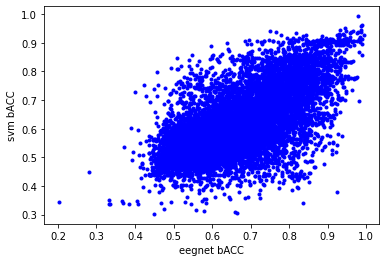

In [65]:
d1 = exps['eegnet'].df.loc[:, 'bACC'].values
d2 = exps['svm'].df.loc[:, 'bACC'].values

assert len(d1) == len(d2)

%matplotlib inline
plt.plot(d1, d2, '.b', )
plt.xlabel('eegnet bACC')
plt.ylabel('svm bACC')
plt.show()